<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap12_1_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 12 - Redes Neurais Recorrentes

## 12.1 Redes Neurais
Neste notebook Python, iremos descrever sobre as redes multilayer perceptron e como podemos gerar redes neurais profundas.

Para isso, vamos precisar instalar as bibliotecas keras, tensorflow:lioteca numpy:

In [ ]:
!pip install -U keras
!pip install tensorflow

In [2]:
from keras.models import Sequential,Model
from keras.layers import Dense,Activation,Input,SimpleRNN
import numpy as np

## 12.1. Definição

Suponha um texto que possua a seguinte sequência de palavras $x_1, x_2, \ldots, x_N$. De acordo com Goodfellow, uma rede neural recorrente pode ser matematicamente definida pelas seguintes equações:

\begin{equation}
h^t = tanh(W_x \cdot e^t + W_h h^{t-1} + b)
\end{equation}

\begin{equation}
y^t = \sigma(W_y \cdot h^t + c)
\end{equation}


Modelo de neurônio com recebimento de entrada referente ao estado anterior (da esquerda para a direita):


*   $x_t$: é uma palavra do texto;
*   Camada de embedding: recebe uma representação numérica da palavra (em bits por one-hot encoding, ou um número inteiro) e gera um vetor de tamanho fixo (no exemplo, todas as palavras são codificadas em um vetor de 3 dimensões). Tal camada possui pesos que são ajustados durante o treinamento, fazendo com que os vetores gerados expressem as relações de dependência entre as palavras (o contexto!);
*   $b$ e $c$ são os vieses (biases) das funções de transferência;
*   $W_x$: os pesos referentes aos neurônios (de entrada) que recebem o vetor de embedding da palavra;
*   $W_h$: os pesos referentes aos neurônios (de entrada) que recebem o vetor do estado anterior da (célula) RNN;
*   $W_y$: os pesos referentes aos neurônios relacionados à geração da saída da RNN;
*   $\hat{y}^t$: é a saída da rede. A saída pode estar codificada na forma logits, bastando incluir mais neurônios na camada de saída de acordo com a quantidade de bits alterar a função sigmóide $\sigma$ para uma *softmax*.




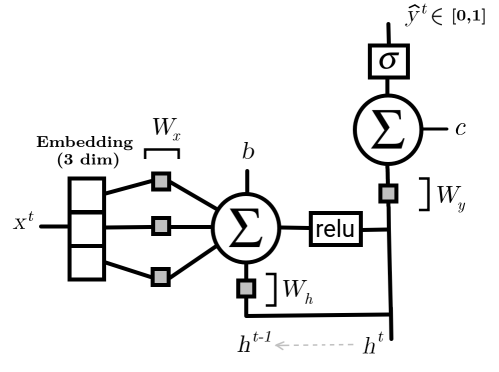

## RNN no Keras

A forma mais básica de implementação de uma rede neural recorrente no Keras é por meio da classe [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN).

Os principais parâmetros são:

*   units;
*   return_sequences;
*   return_state.


### Quantidade de neurônios internos

**units** se trata de um hiperparâmetro relacionado à dimensionalidade do espaço da saída.

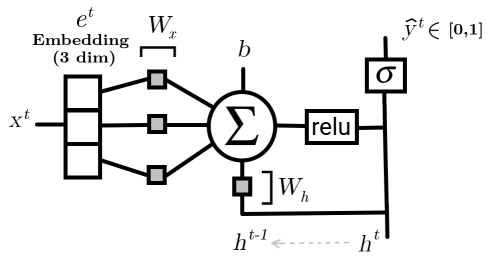

In [3]:
input1 = Input(shape=(1,3))
rnn_output = SimpleRNN(1,activation='relu')(input1)
model = Model(inputs=input1,outputs=rnn_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Pode-se ver que a arquitetura acima possui uma célula RNN simples e uma entrada com três dimensões. Nessa célula RNN, o único neurônio possui três pesos $W_x$, o bias do neurônio e o peso $W_h$ do estado $h_{t-1}$. As saídas $h_t$ e $y_t$ possuem dimensão $1$.

No total, temos então $5$ parâmetros que serão ajustados durante o processo de treinamento.

No exemplo abaixo, vamos gerar como saídas dois vetores bidimensionais $\mathbf{h_t} = [h^t_0,h^t_1]$ e $\mathbf{y_t} = [y^t_0,y^t_1]$. Para esse propósito, precisaremos de dois neurônios internos à célula RNN: 

In [4]:
input1 = Input(shape=(1,3))
rnn_output = SimpleRNN(2,activation='relu')(input1)
model = Model(inputs=input1,outputs=rnn_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 2)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


Assim, existem $6$ pesos em $W_x$ (3 em cada neurônio), $2$ biases em cada neurônio, e $4$ pesos $W_h$ que balanceiam os estados anteriores. Temos então $12$ parâmetros.

**Termo geral**

Total de parâmetros = *units* $\times$ d + *units* + 2 $\times$ *units*

em que $d$ é a dimensionalidade do espaço de entrada.

### return_sequences

O modelo de neurônio implementado na SimpleRNN é do tipo many-to-one, isto é, em cada instante de tempo, uma entrada é lida, mas apenas a última saída é retornada, como mostra a figura abaixo:

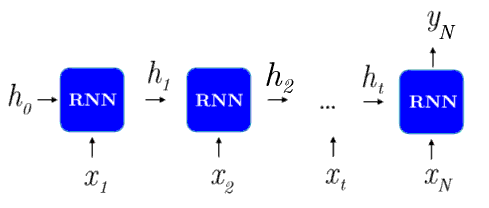

In [9]:
from keras.models import Model,Sequential
from keras.layers import Input,SimpleRNN,Dropout,Embedding,Dense

input1 = Input(shape=(3,1))
rnn_output = SimpleRNN(1,activation='relu')(input1)
model = Model(inputs=input1,outputs=rnn_output)

t = np.array([0.4,0.6,0.3])
p = model.predict(t.reshape(1,3,1))
print(p)

[[0.21616466]]


Para que a camada SimpleRNN retorne todas as saídas geradas em cada instante de tempo, deve-se habilitar a flag `return_sequences=True`.

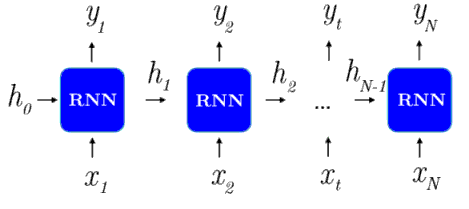

Veja um exemplo:

In [10]:
input1 = Input(shape=(3,1))
rnn_output = SimpleRNN(1,return_sequences=True,activation='relu')(input1)
model = Model(inputs=input1,outputs=rnn_output)

t = np.array([0.4,0.6,0.3])
p = model.predict(t.reshape(1,3,1))
print(p)

[[[0.0028439 ]
  [0.00142195]
  [0.00071098]]]


Tal comando é fundamental ao construir arquiteturas com várias RNNs empilhadas como mostra o comando abaixo:

In [14]:
input1 = Input(shape=(3,1))
rnn_output_1 = SimpleRNN(1,return_sequences=True,activation='relu')(input1)
rnn_output_2 = SimpleRNN(1,activation='relu')(rnn_output_1)
model = Model(inputs=input1,outputs=rnn_output_2)

t = np.array([0.4,0.6,0.3])
p = model.predict(t.reshape(1,3,1))
print(p)

[[0.]]
